In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import pickle
import numpy as np

from tqdm import tnrange, tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Import data and make dataset

In [2]:
X_train = pickle.load(open('Data/classification/X_train.pkl', 'rb'))
y_train = pickle.load(open('Data/classification/y_train.pkl', 'rb'))
X_test = pickle.load(open('Data/classification/X_test.pkl', 'rb'))
y_test = pickle.load(open('Data/classification/y_test.pkl', 'rb'))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [3]:
X_train.shape

(115779, 5, 200)

In [4]:
X_val.shape

(28945, 5, 200)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
val_ds = TensorDataset(X_val, y_val)

In [6]:
test = X_train[0].unsqueeze(0)

# conv1 = nn.Conv1d(5, 16, 5)
# conv2 = nn.Conv1d(16, 32, 5)
# nn.MaxPool1d(2)

# result1 = conv1(test)

# result2 = conv2(result1)

# result1.shape, result2.shape

# fc = nn.Linear(result2.shape[1]*result2.shape[2], 256)

# final = fc(result2.view(result2.size(0), -1))

# final.shape

## Define regression model

In [6]:
class LeNet_1D(nn.Module):
    def __init__(self, input_channel=5, dropout=0):
        super(LeNet_1D, self).__init__()

        self.conv1 = nn.Conv1d(input_channel, 16, 5)
        self.conv2 = nn.Conv1d(16, 32, 5)

        self.fc1 = nn.Linear(32*47, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)

        self.convolutions = nn.Sequential(
            self.conv1,  # 5 -> 16
            nn.MaxPool1d(2),
            self.conv2,  # 16 -> 32
            nn.MaxPool1d(2)
        )
        self.linears = nn.Sequential(
            self.fc1,
            nn.LeakyReLU(),
            self.fc2,
            nn.LeakyReLU(),
            self.fc3
        )

    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.linears(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## training

In [7]:
def train(net, trainloader):
    net.train()
    
    lossSum = 0
    idx = 0
    
    for X, y in tqdm_notebook(trainloader, desc='dataset loop:'):
        X, y = X.to(device), y.to(device)
        idx += 1
        predict = net(X)
        
        optimizer.zero_grad()
        loss = criterion(predict, y)
        lossSum += loss.item()
        loss.backward()
        optimizer.step()
    
    return lossSum / idx


def validation(net, validationloader):
    net.eval()
    
    lossSum = 0
    idx = 0
    
    for X, y in validationloader:
        X, y = X.to(device), y.to(device)
        idx += 1
        predict = net(X)
        loss = criterion(predict, y)
        lossSum += loss.item()
    
    return lossSum / idx

In [8]:
net = LeNet_1D()
EPOCH = 200
gpu_idx = 0
batch_size = 50
learning_rate = 1e-3
weight_decay = 5e-6
tloss = []
vloss = []

device = 'cuda:%d' % gpu_idx if torch.cuda.is_available() else 'cpu'

trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
validationloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=10)

criterion = getattr(nn, 'MSELoss')()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training Code

In [9]:
import copy

In [16]:
best_model = None
best_val = 9999999
for epoch in tnrange(EPOCH, desc='epoch loop:'):
    net.to(device)
    train_loss = train(net, trainloader)
    val_loss = validation(net, validationloader)
    tloss.append(train_loss)
    vloss.append(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        best_model = copy.deepcopy(net.cpu())

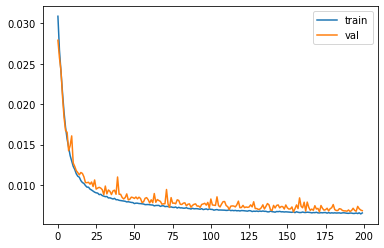

In [18]:
plt.plot(tloss, label='train')
plt.plot(vloss, label='val')
plt.legend()

In [19]:
np.argmin(vloss)

154

In [25]:
np.min(vloss)

0.006655439393858656

In [21]:
torch.save(best_model.state_dict(), 'model_save/best_classification_model.pt')

In [23]:
test_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=10)

In [21]:
state_dict = torch.load('model_save/best_classification_model.pt')

In [22]:
state_dict

OrderedDict([('conv1.weight',
              tensor([[[-8.1744e-02, -1.7900e-02, -4.2454e-02, -7.2409e-02,  2.0614e-01],
                       [-1.3506e-01, -1.0653e-01,  1.5693e-02,  9.2621e-02,  1.1218e-01],
                       [ 1.2766e-02, -1.9916e-03, -1.1625e-01, -1.5355e-01,  2.4634e-01],
                       [-2.4966e-02, -1.6224e-02,  2.3258e-03,  1.6022e-02,  2.3933e-02],
                       [-2.6084e-02, -3.5043e-02,  5.5017e-03, -4.8033e-02,  1.8157e-02]],
              
                      [[ 1.0889e+00,  1.1501e+00,  8.2773e-02, -9.0991e-01, -1.4717e+00],
                       [-4.8061e-02, -2.5630e-01, -1.2328e-01,  6.6861e-02,  2.7258e-01],
                       [-1.6483e-01,  7.9645e-03,  5.4228e-02,  2.1428e-01, -1.2672e-01],
                       [ 3.0293e-02,  2.3756e-03, -1.7295e-02, -3.6263e-02, -4.3474e-02],
                       [-1.9742e-02,  4.2051e-02, -1.0715e-02, -5.6799e-03,  6.3125e-02]],
              
                      [[ 1.2821e-01,  

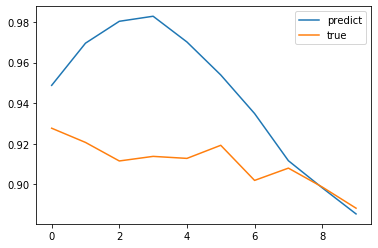

In [24]:
best_model.to(device)
best_model.eval()

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    
    predict = best_model(X)
    
    break

plt.plot(predict.cpu().detach().numpy().squeeze(), label='predict')
plt.plot(y.cpu().detach().numpy().squeeze(), label='true')
plt.legend()

## Adversarial Attack

In [26]:
from advertorch.attacks import LinfPGDAttack

In [ ]:
adversary = LinfPGDAttack(
    best_model, loss_fn=nn.MSELoss(), eps=0.3,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adv_untargeted = adversary.perturb(cln_data, true_label)

target = torch.ones_like(true_label) * 3